## Inferring Cosmology and Astrophysics with observations of gravitational waves (ICAROGW)

IcaroGW is a package used to estimate population proprerties (mass and redshift distributions) together with cosmology from LIGO, Virgo, Kagra gravitational waves observations.

This notebook will show some of the main functionalities of ICAROGW and it will give few examples on how to calculate all the quantities needed to perform an hierarchical inference. For more details about the statistical method, please refer to [S. Mastrogiovanni et al](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.104.062009).

### Basics of the statistical method

Given a set of population parameters $\Lambda$ and GW events $\{x\}$, the posterior on them can be calculated using the following formula

$$p(\Lambda|\{x\}) \propto e^{-N_{\rm exp}(\Lambda)}[N_{\rm exp}(\Lambda)]^{N_{\rm obs}} \frac{\prod_i^{N_{\rm obs}} \int \mathcal{L}(x_i|\theta)p_{\rm pop}(\theta|\Lambda) d\theta}{[\int p_{\rm det}(\theta,\Lambda)p_{\rm pop}(\theta|\Lambda) d\theta]^{N_{\rm obs}}}$$

where 

* $N_{\rm exp}(\Lambda)$ is the number of expected GW detections in a given observation time and detector network.
* $N_{\rm obs}$ is the number of observed events in this perior.
* $\mathcal{L}(x_i|\theta)$ is the GW likelihood as a function of all the binary parameters, such as redshift, source masses  etc.
* $p_{\rm pop}(\theta|\Lambda)$ is a prior describing the population distribution given some population level parameters. We usually fit for this.
* $p_{\rm det}(\theta,\Lambda)$ is the detection probability for a GW event. This serves to correct selection biases.

The term in the square brackets of the denominator of the above Eq. is usually referred to as **selection bias** and takes into account how common is to detect a GW event given a population or cosmological model.


In [1]:
import icarogw
import matplotlib.pyplot as plt
import corner
import numpy as np
import pickle
import h5py
import pickle

## The cosmology class

The cosmology module is one of the key blocks of icarogw. It contains classes for several cosmological models that you can initiate with various parameters. You can use these cosmology classes to calculate redshift, luminosity distance, differential comoving volume etc. Just check for the class methods.

Text(0, 0.5, 'dl [Mpc]')

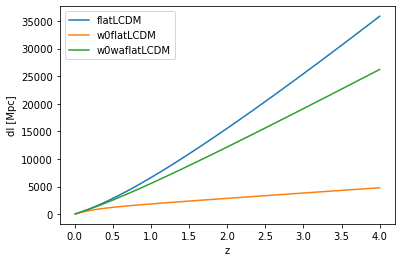

In [2]:
z_array = np.linspace(0.01,4,1000)
FLCDM_cosmo=icarogw.cosmologies.flatLCDM(H0=70,Omega_m=0.3)
w0FLCDM_cosmo=icarogw.cosmologies.w0flatLCDM(H0=70,Omega_m=0.3,w0=3)
w0waFLCDM_cosmo=icarogw.cosmologies.w0waflatLCDM(H0=70,Omega_m=0.3,w0=-0.5,wa=1)

plt.plot(z_array,FLCDM_cosmo.dl_at_z(z_array),label='flatLCDM')
plt.plot(z_array,w0FLCDM_cosmo.dl_at_z(z_array),label='w0flatLCDM')
plt.plot(z_array,w0waFLCDM_cosmo.dl_at_z(z_array),label='w0waflatLCDM')
plt.legend()
plt.xlabel('z')
plt.ylabel('dl [Mpc]')

## The populaiton priors

Icarogw also provides classes to calculate the population priors on source masses and redshift

### Population priors on masses

Icarogw containts 4 phenomenological models for the source masses. For more details see the documentation. These models can be used to calculate the probability $p_{\rm pop}(m_1,m_2)$ but also draw from it

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:161: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:159: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select

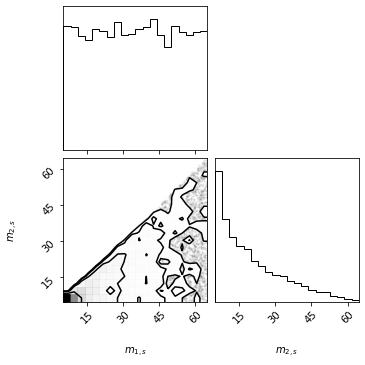

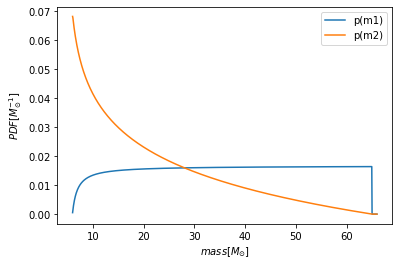

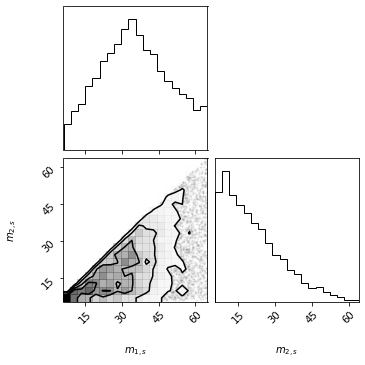

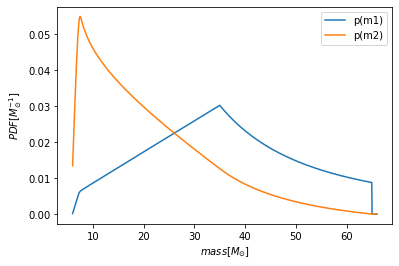

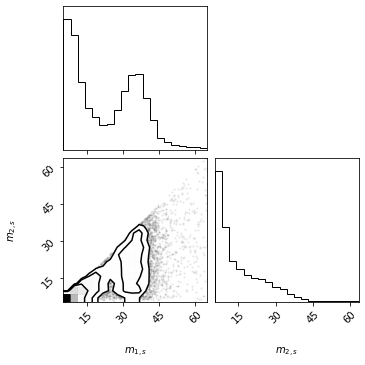

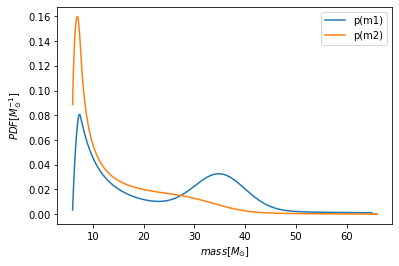

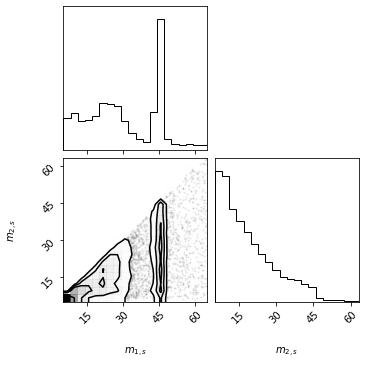

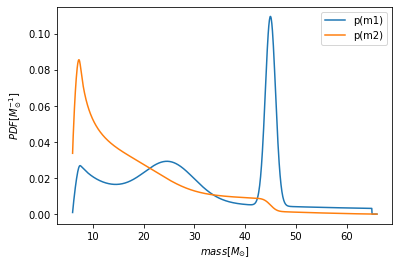

In [3]:
Nsamp = 10000 #Number of binaries you want to generate from the prior

# Defines a mass grid where to compute the prior
mass = np.linspace(6,66,1000)
M1, M2 = np.meshgrid(mass,mass)

# Models in icarogw
names=['BBH-powerlaw','BBH-broken-powerlaw','BBH-powerlaw-gaussian','BBH-powerlaw-double-gaussian']

for name in names:
    
    # Initialize the models with some parameters. 
    if name=='BBH-powerlaw':
        dic_param = {'alpha':0,'beta':0,'mmin':5.,'mmax':65}
    elif name=='BBH-broken-powerlaw':
        dic_param = {'alpha_1':-1.,'alpha_2':2,'beta':0.,'mmin':5.,'mmax':65.,'b':0.5,'delta_m':3}
    elif name=='BBH-powerlaw-gaussian':
        dic_param = {'alpha':2.,'beta':0.,'mmin':5.,'mmax':65.,'mu_g':35.,
                    'sigma_g':5,'lambda_peak':0.3,'delta_m':3}
    elif name=='BBH-powerlaw-double-gaussian':
        dic_param = {'alpha':1.,'beta':0.,'mmin':5.,'mmax':65.,'mu_g_low':25.,
                    'sigma_g_low':5,'mu_g_high':45,'sigma_g_high':1,'lambda_g':0.5
                    ,'lambda_g_low':0.5,'delta_m':3}
        

    # Initialize the mass prior
    mp = icarogw.priors.mass.mass_prior(name,hyper_params_dict=dic_param)
    # Sample m1 and m2 from the mass prior and histogram it
    _ = corner.corner(np.column_stack(mp.sample(Nsamp)),labels=[r'$m_{1,s}$',r'$m_{2,s}$'])
    
    # Calculates p(m1,m2) on the grid of masses
    ppp=mp.joint_prob(M1,M2)

    # Calculates the marginal distributions from the grid
    marg_m1=np.trapz(ppp,mass,axis=0)
    marg_m2=np.trapz(ppp,mass,axis=1)

    # Compares the histograms generated from the monte carlo draws and the analytical distributions
    plt.figure()
    plt.plot(mass,marg_m1,label='p(m1)')
    plt.plot(mass,marg_m2,label='p(m2)')
    plt.xlabel(r'$mass [M_{\odot}]$')
    plt.ylabel(r'$PDF [M^{-1}_{\odot}]$')
    plt.legend()

### Population priors on redshift

Icarogw also contains a class for redshif priors. We have two models available, see the documentation for more details

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:82: RuntimeWarning: divide by zero encountered in log
  return _np.log(self.cosmo.dVc_by_dz(z_vals))-_np.log1p(z_vals)+self.log_rate_eval(z_vals)-_np.log(self.norm_fact)
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/

Text(0, 0.5, 'Prior')

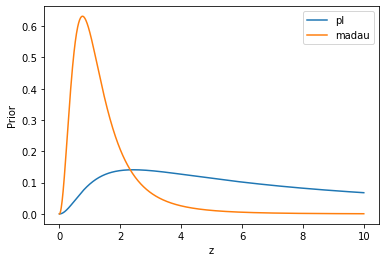

In [4]:
z_array = np.linspace(0,10,1000)
# Initialize the cosmology. This is needed for the redshift prior.
cosmo = icarogw.cosmologies.flatLCDM()

# Initialize the redshift prior, we are using the a powerlaw merger rate evolution model 
zp_pl = icarogw.priors.redshift.redshift_prior(cosmo,'powerlaw',{'gamma':1.})
# Plot the prior
plt.plot(z_array,zp_pl.prob(z_array),label='pl')

# Initializethe redshift prior, we are using a Madau like rate evolution model
zp_pl = icarogw.priors.redshift.redshift_prior(cosmo,'madau',{'gamma':1.,'kappa':3.,'zp':0.5})
plt.plot(z_array,zp_pl.prob(z_array),label='madau')
plt.legend()
plt.xlabel('z')
plt.ylabel('Prior')


## Injections file creation and tests

Icarogw uses list of injections to evaluate selection biases but also number of expected signals for a given run. Below we are going to see how to calculate these numbers starting from a list of injections

In [5]:
# Uncomment to download in injection file from O2 and the LIGO and Virgo collaboration
#!wget https://dcc.ligo.org/public/0171/P2000434/003/injections_O1O2an_spin.h5

In [6]:
# The injection set that we are using is generated for a fixwed cosmology. Below we set the reference cosmology
H0_ref = 67.7 # H0 used for injections
Om0_ref = 0.308
cosmo_ref = icarogw.cosmologies.flatLCDM(Omega_m=Om0_ref,H0=H0_ref)

# We read the file
f2 = h5py.File('injections_O1O2an_spin.h5','r')

# Defines the time span in years of O1 and O2 considering a 60% duty cycle
tO1O2 = ((129+272)/365)*0.6
tot_time = tO1O2

# We need to tell the code how many signals we simulated, even the non detected ones
nO1O2=f2['sampling_pdf'].attrs['Ndraw']
ntot=nO1O2

# Extract the masses, redshift, redshift and priors used to draw the simulated signals. 
ms1 = f2['mass1_source'][()]
ms2 = f2['mass2_source'][()]
z= f2['redshift'][()]
snr_det= f2['snr_observed'][()]
far=np.ones_like(f2['snr_observed'])*np.inf # This injection set does not contain IFAR, so we set it to infinity
prior_vals=f2['sampling_pdf'][()]*4 # Multiply by 4 to remove the spin prior


injections = icarogw.injections.injections_at_source(cosmo_ref=cosmo_ref,m1s=ms1,m2s=ms2,z=z,
    prior_vals=prior_vals, snr_det=snr_det,
    snr_cut=12,ifar_cut=1,ifar=far, # Generate an injection set with a SNR cut for detection of 12 and IFAR cut of 1
    ntotal=ntot,Tobs=tot_time)

In [7]:
# We initialize here a prior model for redshift and mass

zp = icarogw.priors.redshift.redshift_prior(cosmo_ref,'powerlaw',dic_param={'gamma':2.7})
mass_hp = {'alpha':2.4,'beta':0,'mmin':5,'mmax':80}
mp = icarogw.priors.mass.mass_prior(name='BBH-powerlaw',hyper_params_dict=mass_hp)

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))


In [8]:
# We update the injection model
injections.update_VT(mp,zp)
# We print the number of expected detections in O1 and O2 with SNR>12
print(injections.expected_number_detection(20)) # 20= merger rate today in Gpc-3 yr-1

4.282121918187997


/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


In [9]:
# We can update the cut to an SNR cut of 11 ad check how many events more I expect
injections.update_cut(snr_cut=11,ifar_cut=0)
injections.update_VT(mp,zp)
print(injections.expected_number_detection(20)) #20= merger rate today in Gpc-3 yr-1

Selecting injections with SNR 11.000000 and IFAR 0.000000 yr
5.176890523457098


# Analysis tests

In this part we are going to see how to perform some simple analysis based on O1 and O2 BBHs.

## Simple analysis on population grid

We are going to show how to run an analysis using discrete populaton models. In this case, we will just fix the population model for BBHs and run the analysis only on the Hubble constant

In [10]:
# Select all O1 and O2 BBHs with SNR cut>2
list_ev = icarogw.utils.quick_init.initialize_events_dict(runs=['O1','O2'],type='BBH',snr_cut=12)


In [11]:
# Get the posterior samples, please uncomment these lines
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW151226_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170104_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170608_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170809_GWTC-1.hdf5
# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170814_GWTC-1.hdf5



In [22]:
import icarogw
from icarogw.posterior_samples import posterior_samples
from icarogw.injections import injections_at_source
from icarogw.priors.mass import mass_prior
from icarogw.priors.redshift import redshift_prior
from icarogw.cosmologies import flatLCDM
from icarogw.analyses.cosmo_pop_rate_marginalized import hierarchical_analysis
import numpy as np
import matplotlib.pyplot as plt
import pickle


H0_array=np.linspace(50,140,100) # H0 at which you want to study

mass_hp = {'alpha':2.5,'beta':1.0,'mmin':5,'mmax':60}
mp = mass_prior(name='BBH-powerlaw',hyper_params_dict=mass_hp)
mp_list = [mp for i in range(100)] # Defines a list of population priors for masses, all equal
cosmo_list = [flatLCDM(H0=H0) for H0 in H0_array] # Defines a list of cosmology, here we are changing H0
zp_pl = [redshift_prior(cosmo,'powerlaw',{'gamma':0}) for cosmo in cosmo_list] # Defines a uniform in comoving volume prior

injections.update_cut(snr_cut=12,ifar_cut=0) # We are going to update the injections with the new SNR cut to 12

# Read the posterior samples
posterior_dict = {}
for event in list(list_ev.keys()):
    print(event)    
    filename = event+'_GWTC-1.hdf5'
        
    pos_samples = posterior_samples(filename)
    posterior_dict[event]=pos_samples
    
analysis = hierarchical_analysis(posterior_dict,injections) # Initialize the analysis
single_posterior = analysis.run_analysis_on_lists(mp_list,zp_pl) # Run the analysis on the list of population models

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


Selecting injections with SNR 12.000000 and IFAR 0.000000 yr
GW150914
Using Overall_posterior posterior with a total of 8350 samples
GW151226
Using Overall_posterior posterior with a total of 52252 samples
GW170104
Using Overall_posterior posterior with a total of 24972 samples
GW170608
Using Overall_posterior posterior with a total of 6448 samples
GW170809
Using Overall_posterior posterior with a total of 14802 samples
GW170814
Using Overall_posterior posterior with a total of 40000 samples


100% |########################################################################|


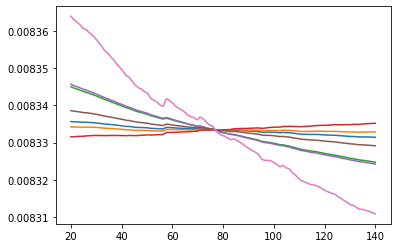

In [24]:
# Just combining posteriors with this script. You might want to add a smoothing factor when multiplying posteriors
combined = np.zeros(100)
for key in list(single_posterior.keys()):
    combined+=single_posterior[key]
    combined-=combined.max()
    single_posterior[key] = np.exp(single_posterior[key])
    single_posterior[key]/= np.trapz(single_posterior[key],np.linspace(20,140,100))
    plt.plot(np.linspace(20,140,100),single_posterior[key])
combined=np.exp(combined)
combined/=np.trapz(combined,np.linspace(20,140,100))
plt.plot(np.linspace(20,140,100),combined)

## MCMC population analysis

Icarogw is also implemented with Bilby and can be used to run an MCMC sampling for more population parameters at the same time.

In [27]:
ls

GW150914_GWTC-1.hdf5    GW170104_GWTC-1.hdf5.1  GW170814_GWTC-1.hdf5
GW150914_GWTC-1.hdf5.1  GW170608_GWTC-1.hdf5    injections_O1O2an_spin.h5
GW151226_GWTC-1.hdf5    GW170608_GWTC-1.hdf5.1  tutorial.ipynb
GW151226_GWTC-1.hdf5.1  GW170809_GWTC-1.hdf5
GW170104_GWTC-1.hdf5    GW170809_GWTC-1.hdf5.1


17:02 bilby INFO    : Running for label 'dynesty_3', output will be saved to 'H0_GWTC-1_PL_2/'
17:02 bilby INFO    : Search parameters:
17:02 bilby INFO    :   mmax = Uniform(minimum=30, maximum=100, name='mmax', latex_label='mmax', unit=None, boundary=None)
17:02 bilby INFO    :   H0 = Uniform(minimum=20, maximum=120, name='H0', latex_label='H0', unit=None, boundary=None)
17:02 bilby INFO    :   gamma = 0
17:02 bilby INFO    :   alpha = 1.6
17:02 bilby INFO    :   beta = 0.0
17:02 bilby INFO    :   mmin = 5
17:02 bilby INFO    :   Om0 = 0.308


Selecting injections with SNR 12.000000 and IFAR 0.000000 yr
GW150914
Using Overall_posterior posterior with a total of 8350 samples
GW151226
Using Overall_posterior posterior with a total of 52252 samples
GW170104
Using Overall_posterior posterior with a total of 24972 samples
GW170608
Using Overall_posterior posterior with a total of 6448 samples
GW170809
Using Overall_posterior posterior with a total of 14802 samples
GW170814
Using Overall_posterior posterior with a total of 40000 samples
Using the parallel mode with 2000 samples


/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/analyses/cosmo_pop_rate_marginalized.py:183: RuntimeWarning: invalid value encountered in subtract
  Neff_vect=_np.exp(2*log_sum_weights-log_sum_weights_squared)
17:02 bilby INFO    : Single likelihood evaluation took 1.929e-02 s


0it [00:00, ?it/s]

17:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 20, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff374048c70>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 2}
17:02 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:02 bilby INFO    : Using dynesty version 1.0.1
17:02 bilby INFO    : Using the bilby-implemented rwalk sampl

1839it [05:25,  1.87it/s, bound:0 nc: 39 ncall:1.8e+04 eff:10.0% logz=-149.20+/-0.07 dlogz:0.284>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1849it [05:30,  2.02it/s, bound:1 nc: 31 ncall:1.9e+04 eff:9.9% logz=-149.19+/-0.07 dlogz:0.278>0.1] 

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1860it [05:35,  2.09it/s, bound:2 nc: 32 ncall:1.9e+04 eff:9.8% logz=-149.19+/-0.07 dlogz:0.271>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1872it [05:41,  1.92it/s, bound:3 nc: 25 ncall:1.9e+04 eff:9.7% logz=-149.18+/-0.07 dlogz:0.264>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1883it [05:47,  2.44it/s, bound:4 nc: 23 ncall:2.0e+04 eff:9.6% logz=-149.18+/-0.07 dlogz:0.258>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1894it [05:52,  2.32it/s, bound:5 nc: 31 ncall:2.0e+04 eff:9.5% logz=-149.17+/-0.07 dlogz:0.252>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1905it [05:57,  2.13it/s, bound:6 nc: 31 ncall:2.0e+04 eff:9.4% logz=-149.17+/-0.07 dlogz:0.247>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1916it [06:02,  2.30it/s, bound:7 nc: 28 ncall:2.1e+04 eff:9.3% logz=-149.16+/-0.07 dlogz:0.241>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1927it [06:06,  2.19it/s, bound:8 nc: 30 ncall:2.1e+04 eff:9.2% logz=-149.16+/-0.07 dlogz:0.236>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1938it [06:11,  2.27it/s, bound:9 nc: 30 ncall:2.1e+04 eff:9.1% logz=-149.16+/-0.07 dlogz:0.230>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1950it [06:17,  1.88it/s, bound:10 nc: 32 ncall:2.2e+04 eff:9.1% logz=-149.15+/-0.07 dlogz:0.224>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1961it [06:24,  1.36it/s, bound:11 nc: 56 ncall:2.2e+04 eff:9.0% logz=-149.15+/-0.07 dlogz:0.219>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1972it [06:30,  1.88it/s, bound:12 nc: 29 ncall:2.2e+04 eff:8.9% logz=-149.14+/-0.07 dlogz:0.214>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1983it [06:35,  2.21it/s, bound:13 nc: 29 ncall:2.3e+04 eff:8.8% logz=-149.14+/-0.07 dlogz:0.209>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


1994it [06:40,  2.00it/s, bound:14 nc: 35 ncall:2.3e+04 eff:8.7% logz=-149.14+/-0.07 dlogz:0.204>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2005it [06:46,  2.27it/s, bound:15 nc: 23 ncall:2.3e+04 eff:8.7% logz=-149.13+/-0.07 dlogz:0.200>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2016it [06:51,  2.09it/s, bound:16 nc: 31 ncall:2.3e+04 eff:8.6% logz=-149.13+/-0.07 dlogz:0.195>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2027it [06:56,  1.91it/s, bound:17 nc: 35 ncall:2.4e+04 eff:8.5% logz=-149.12+/-0.07 dlogz:0.191>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2039it [07:02,  2.20it/s, bound:18 nc: 25 ncall:2.4e+04 eff:8.5% logz=-149.12+/-0.07 dlogz:0.186>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2048it [07:07,  1.69it/s, bound:19 nc: 32 ncall:2.4e+04 eff:8.4% logz=-149.12+/-0.07 dlogz:0.182>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2059it [07:12,  1.91it/s, bound:20 nc: 33 ncall:2.5e+04 eff:8.3% logz=-149.12+/-0.07 dlogz:0.178>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2070it [07:18,  2.05it/s, bound:21 nc: 29 ncall:2.5e+04 eff:8.3% logz=-149.11+/-0.07 dlogz:0.174>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2080it [07:24,  1.44it/s, bound:22 nc: 55 ncall:2.5e+04 eff:8.2% logz=-149.11+/-0.07 dlogz:0.170>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2091it [07:30,  2.00it/s, bound:23 nc: 29 ncall:2.6e+04 eff:8.2% logz=-149.11+/-0.07 dlogz:0.167>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2103it [07:36,  1.85it/s, bound:24 nc: 31 ncall:2.6e+04 eff:8.1% logz=-149.10+/-0.07 dlogz:0.162>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2113it [07:41,  1.82it/s, bound:25 nc: 30 ncall:2.6e+04 eff:8.0% logz=-149.10+/-0.07 dlogz:0.159>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2124it [07:48,  1.67it/s, bound:26 nc: 33 ncall:2.7e+04 eff:8.0% logz=-149.10+/-0.07 dlogz:0.155>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2135it [07:53,  2.02it/s, bound:27 nc: 31 ncall:2.7e+04 eff:7.9% logz=-149.09+/-0.07 dlogz:0.152>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2146it [07:59,  1.81it/s, bound:28 nc: 25 ncall:2.7e+04 eff:7.9% logz=-149.09+/-0.07 dlogz:0.148>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2158it [08:06,  1.83it/s, bound:29 nc: 28 ncall:2.8e+04 eff:7.8% logz=-149.09+/-0.07 dlogz:0.145>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2170it [08:12,  1.83it/s, bound:30 nc: 25 ncall:2.8e+04 eff:7.8% logz=-149.09+/-0.07 dlogz:0.141>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2181it [08:19,  1.82it/s, bound:31 nc: 29 ncall:2.8e+04 eff:7.7% logz=-149.08+/-0.07 dlogz:0.138>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2193it [08:25,  2.01it/s, bound:32 nc: 22 ncall:2.8e+04 eff:7.7% logz=-149.08+/-0.07 dlogz:0.135>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2203it [08:31,  1.76it/s, bound:33 nc: 27 ncall:2.9e+04 eff:7.7% logz=-149.08+/-0.07 dlogz:0.132>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2214it [08:38,  1.77it/s, bound:34 nc: 30 ncall:2.9e+04 eff:7.6% logz=-149.08+/-0.07 dlogz:0.129>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2226it [08:44,  2.10it/s, bound:35 nc: 24 ncall:2.9e+04 eff:7.6% logz=-149.07+/-0.07 dlogz:0.126>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2237it [08:50,  1.82it/s, bound:36 nc: 27 ncall:3.0e+04 eff:7.5% logz=-149.07+/-0.07 dlogz:0.123>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2249it [08:56,  1.88it/s, bound:37 nc: 28 ncall:3.0e+04 eff:7.5% logz=-149.07+/-0.07 dlogz:0.120>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2261it [09:02,  1.90it/s, bound:38 nc: 28 ncall:3.0e+04 eff:7.5% logz=-149.07+/-0.07 dlogz:0.117>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2272it [09:08,  1.87it/s, bound:39 nc: 29 ncall:3.1e+04 eff:7.4% logz=-149.06+/-0.07 dlogz:0.114>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2279it [09:11,  2.02it/s, bound:40 nc: 26 ncall:3.1e+04 eff:7.4% logz=-149.06+/-0.07 dlogz:0.113>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/analyses/cosmo_pop_rate_marginalized.py:183: RuntimeWarning: invalid value encountered in subtract
  Neff_vect=_np.exp(2*log_sum_weights-log_sum_weights_squared)


2283it [09:14,  1.80it/s, bound:40 nc: 26 ncall:3.1e+04 eff:7.4% logz=-149.06+/-0.07 dlogz:0.112>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2293it [09:19,  1.72it/s, bound:41 nc: 50 ncall:3.1e+04 eff:7.3% logz=-149.06+/-0.07 dlogz:0.109>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2305it [09:25,  2.00it/s, bound:42 nc: 28 ncall:3.2e+04 eff:7.3% logz=-149.06+/-0.07 dlogz:0.107>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2317it [09:31,  2.03it/s, bound:43 nc: 27 ncall:3.2e+04 eff:7.3% logz=-149.06+/-0.07 dlogz:0.104>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2329it [09:37,  2.00it/s, bound:44 nc: 25 ncall:3.2e+04 eff:7.2% logz=-149.05+/-0.07 dlogz:0.101>0.1]

/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/cosmologies.py:107: RuntimeWarning: divide by zero encountered in log10
  return _np.nan_to_num(10.**_splev(_np.log10(z),self.interp_dvc_dz,ext=0))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/redshift.py:65: RuntimeWarning: divide by zero encountered in log
  prior_trial = _np.exp(_np.log(cosmo.dVc_by_dz(z_trial))-_np.log1p(z_trial)+self.log_rate_eval(z_trial))
/home/simone/anaconda3/envs/icarogw_test/lib/python3.9/site-packages/icarogw/priors/custom_math_priors.py:292: RuntimeWarning: invalid value encountered in log
  to_ret = self.alpha*_np.log(x)-_np.log(norms)


2336it [09:41,  1.79it/s, bound:45 nc: 28 ncall:3.2e+04 eff:7.2% logz=-149.05+/-0.07 dlogz:0.100>0.1]

17:12 bilby INFO    : Written checkpoint file H0_GWTC-1_PL_2//dynesty_3_resume.pickle
17:12 bilby INFO    : Writing 1149 current samples to H0_GWTC-1_PL_2//dynesty_3_samples.dat


2336it [09:43,  4.00it/s, bound:45 nc:  1 ncall:3.2e+04 eff:8.7% logz=-148.96+/-0.07 dlogz:0.000>0.1]



17:12 bilby INFO    : Sampling time: 0:09:25.081435
17:12 bilby INFO    : Summary of results:
nsamples: 2836
ln_noise_evidence:    nan
ln_evidence: -148.965 +/-  0.073
ln_bayes_factor:    nan +/-  0.073



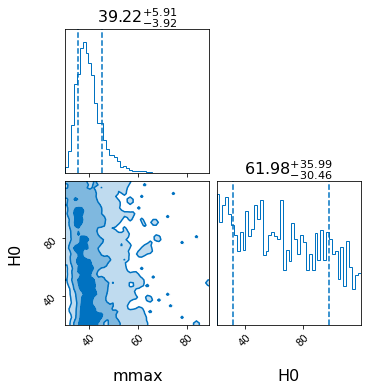

In [29]:
import icarogw
import os
import pickle
import bilby
from icarogw.analyses.cosmo_pop_rate_marginalized import hierarchical_analysis

# Number of injections to use
outdir='H0_GWTC-1_PL_2/'
injections.update_cut(snr_cut=12,ifar_cut=0) # We are going to update the injections with the new SNR cut to 12

# Read the posterior samples
posterior_dict = {}
for event in list(list_ev.keys()):
    print(event)    
    filename = event+'_GWTC-1.hdf5'
        
    pos_samples = posterior_samples(filename)
    posterior_dict[event]=pos_samples

# Setup the priors here. We are going to sample on just H0 and the maximum BH mass for a powerlaw model, just to speed up the code and fixing all the parameters
prior_dict=icarogw.utils.quick_init.initialize_prior_dict('BBH-powerlaw','flatLCDM','powerlaw',True)
prior_dict['alpha']=1.6
prior_dict['beta']=0.
prior_dict['gamma']=0
prior_dict['mmin']=5
prior_dict['Om0']=0.308

analysis = hierarchical_analysis(posterior_dict,injections,scale_free=True)

# Run bilby.  Here we will be using emcee
result = analysis.run_bilby('BBH-powerlaw', 'flatLCDM','powerlaw', prior_dict, 
                            parallel=2000,nlive=500,nact=2,walks=20,outdir=outdir,label='dynesty_3')
result.plot_corner()
